# Transfer Learning Data Size Sweep Analysis

This notebook demonstrates that **transfer learning achieves near-baseline performance with dramatically reduced training requirements** for cosmological emulators. We compare multiple models trained with varying amounts of high-accuracy data:

1. **From-scratch High Accuracy** (10,000 samples) - Our baseline
2. **Transfer Learning Sweep** (200-5,000 samples + frozen low-accuracy weights) - **Our method**
3. **From-scratch Low Accuracy** (10,000 samples) - For context

### Key Results

**Baseline Performance:**
- High Accuracy (10k): **Median Δχ² = 0.054**, **89.1% pass** DES-Y3 threshold
- Low Accuracy (10k): **Median Δχ² = 0.133**, **69.8% pass** DES-Y3 threshold

**Transfer Learning Results:**
- **200 samples**: Median Δχ² = 0.155 (61.2% pass) - 50× reduction in data
- **500 samples**: Median Δχ² = 0.146 (63.2% pass) - 20× reduction in data  
- **1,000 samples**: Median Δχ² = 0.109 (76.8% pass) - **10× reduction in data**
- **1,500 samples**: Median Δχ² = 0.081 (86.1% pass) - 6.7× reduction in data
- **2,500 samples**: Median Δχ² = 0.067 (88.8% pass) - **Matches baseline performance!**
- **5,000 samples**: Median Δχ² = 0.069 (88.2% pass) - Validates convergence

**Key Findings:**
- **2,500 samples achieve baseline-level accuracy** (88.8% vs 89.1% pass rate)
- **4× reduction in training data** while maintaining Stage-IV survey requirements
- **1,000 samples provide reasonable accuracy** (76.8% pass) for preliminary studies
- All transfer models outperform low-accuracy baseline at 1,000+ samples

### Data Vectors
- **ξ±(θ)**: Cosmic shear correlation functions
- **780 elements**: 30 tomographic combinations × 26 angular bins
- **Angular range**: 2.5 to 900 arcmin (log-spaced)
- **DES-Y3 threshold**: Δχ² < 0.2 for Stage-IV surveys

---
## 1. Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import h5py
import sys
from pathlib import Path
import matplotlib.gridspec as gridspec

---
## 2. Load Pre-Trained Models

We load **eight pre-trained ResMLP models** from our data size sweep:

- **Architecture**: 12 → 256 → 256 (3 ResNet blocks) → 780
- **Input**: Cosmological parameters (Ωₘ, σ₈, H₀, etc.)
- **Output**: Cosmic shear data vectors (normalized)

**Models loaded:**
- High Accuracy baseline (10k samples, from scratch)
- Low Accuracy baseline (10k samples, from scratch)
- Transfer Learning models (200, 500, 1000, 1500, 2500, 5000 samples with frozen low-accuracy weights)

In [2]:
# Setup paths
cocoa_base = Path.home() / 'data' / 'bela' / 'cocoa' / 'Cocoa'
sys.path.insert(0, str(cocoa_base / 'projects' / 'lsst_y1'))
from emulator import ResMLP

model_dir = cocoa_base / 'projects' / 'lsst_y1' / 'emulators'

# Reference models (baseline comparisons)
model_paths = {
    'high_acc': model_dir / 'xi_high_accuracy',
    'low_acc': model_dir / 'xi_low_accuracy_original',
}

# Data size sweep models
sweep_dir = model_dir / 'data_size_sweep' / 'models'
sizes = [200, 500, 1000, 1500, 2500, 5000]

print("Reference models:")
for name, path in model_paths.items():
    print(f"  {name}: {path.exists()}")

print("\nSweep models:")
for size in sizes:
    model_path = sweep_dir / f'xi_transfer_{size}'
    exists = model_path.exists()
    if exists:
        model_paths[f'transfer_{size}'] = model_path
    print(f"  transfer_{size}: {exists}")

print(f"\nTotal models to load: {len(model_paths)}")

Reference models:
  high_acc: True
  low_acc: True

Sweep models:
  transfer_200: True
  transfer_500: True
  transfer_1000: True
  transfer_1500: True
  transfer_2500: True
  transfer_5000: True

Total models to load: 8


In [3]:
# Load model architectures and weights
models = {}

# Define h5 file paths for all models
h5_files = {
    'high_acc': model_dir / 'xi_high_accuracy.h5',
    'low_acc': model_dir / 'xi_low_accuracy_original.h5',
}

# Add h5 files for sweep models
for size in sizes:
    key = f'transfer_{size}'
    if key in model_paths:  # Only if model exists
        h5_files[key] = sweep_dir / f'xi_transfer_{size}.h5'

# Model architecture
input_dim = 12      # Cosmological + nuisance parameters  
output_dim = 780    # Data vector elements
hidden_dim = 256    # Hidden layer size

for name, path in model_paths.items():
    # Load model weights
    model = ResMLP(input_dim, output_dim, hidden_dim)
    state_dict = torch.load(path, map_location='cpu')
    model.load_state_dict(state_dict)
    model.eval()
    models[name] = model
    
    print(f"✓ Loaded {name}")

print(f"\n✓ Successfully loaded {len(models)} models")

✓ Loaded high_acc
✓ Loaded low_acc
✓ Loaded transfer_200
✓ Loaded transfer_500
✓ Loaded transfer_1000
✓ Loaded transfer_1500
✓ Loaded transfer_2500
✓ Loaded transfer_5000

✓ Successfully loaded 8 models


---
## 3. Load Test Data

We use **both** high-accuracy and low-accuracy test data generated with CAMB/CoCoA:

**High Accuracy Test Set** (for high_acc and all transfer models):
- **1000 test samples** from the training parameter space
- **12 input parameters** per sample
- **780 data vector elements** (cosmic shear only, avoiding nonlinear regime)

**Low Accuracy Test Set** (for low_acc baseline):
- Same 1000 samples, computed with lower AccuracyBoost
- Ensures fair comparison (models tested on data matching their training fidelity)

In [4]:
# Load test data
data_dir = cocoa_base / 'projects' / 'lsst_y1' / 'data' / 'transfer_learning'

# High accuracy test data (for high_acc model and all transfer models)
X_test_high = np.loadtxt(data_dir / "test_parameters_high_accuracy.txt")
y_test_high_full = np.load(data_dir / "test_datavectors_high_accuracy.npy")
y_test_high = y_test_high_full[:, :780]

# Low accuracy test data (for low_acc model)
X_test_low = np.loadtxt(data_dir / "test_parameters_low_accuracy.txt")
y_test_low_full = np.load(data_dir / "test_datavectors_low_accuracy.npy")
y_test_low = y_test_low_full[:, :780]

print("Test data loaded:")
print(f"  High accuracy: X={X_test_high.shape}, y={y_test_high.shape}")
print(f"  Low accuracy:  X={X_test_low.shape}, y={y_test_low.shape}")

Test data loaded:
  High accuracy: X=(1000, 12), y=(1000, 780)
  Low accuracy:  X=(1000, 12), y=(1000, 780)


In [5]:
# Define data vector structure
n_theta_bins = 26           # Angular bins
n_tomo_combinations = 15    # Unique tomographic pairs: 5×(5+1)/2
n_correlation_functions = 2  # ξ+ and ξ-

xi_plus_size = n_tomo_combinations * n_theta_bins  # 390 elements
xi_minus_start = xi_plus_size                       # Starts at index 390

# Angular bins (log-spaced from 2.5 to 900 arcmin)
theta_bins = np.logspace(np.log10(2.5), np.log10(900), n_theta_bins)

print("Data vector structure:")
print(f"  ξ+: indices 0-{xi_plus_size-1} ({xi_plus_size} elements)")
print(f"  ξ-: indices {xi_minus_start}-779 ({780-xi_minus_start} elements)")
print(f"\nAngular bins: {theta_bins[[0, -1]]} arcmin (min, max)")

Data vector structure:
  ξ+: indices 0-389 (390 elements)
  ξ-: indices 390-779 (390 elements)

Angular bins: [  2.5 900. ] arcmin (min, max)


---
## 4. Generate Predictions

**Critical Preprocessing:** Models expect inputs preprocessed as:  
```python
X_preprocessed = (X - mean) / (5 * std)  # Note the factor of 5!
```

**Model-specific handling:**
- `low_acc` model: Uses low-accuracy test data (`X_test_low`, `y_test_low`)
- All other models: Use high-accuracy test data (`X_test_high`, `y_test_high`)

This ensures each model is evaluated against ground truth matching its training data fidelity.

In [6]:
# Generate predictions with correct input preprocessing
predictions = {}
y_test_normalized = {}

print("Generating predictions...\n")

# Get all model names (high_acc, low_acc, transfer_200, transfer_500, etc.)
model_names = list(models.keys())

for name in model_names:
    # Load normalization parameters from h5 file
    with h5py.File(h5_files[name], 'r') as f:
        samples_mean = f['sample_mean'][:]
        samples_std = f['sample_std'][:]
        dv_evals = f['dv_evals'][:][:780]
        dv_evecs = f['dv_evecs'][:][:780, :780]
        dv_fid = f['dv_fid'][:][:780]
    
    # Use appropriate test data based on model type
    if name == 'low_acc':
        X_current = X_test_low
        y_current = y_test_low
    else:
        X_current = X_test_high
        y_current = y_test_high
    
    # Preprocess inputs with factor of 5
    X_preprocessed = (X_current - samples_mean) / (5 * samples_std)
    X_torch = torch.FloatTensor(X_preprocessed)
    
    # Generate predictions
    with torch.no_grad():
        pred = models[name](X_torch).numpy()
    
    predictions[name] = pred
    
    # Normalize y_test to same space for comparison
    y_test_norm = (y_current - dv_fid) @ dv_evecs / np.sqrt(dv_evals)
    y_test_normalized[name] = y_test_norm
    
    print(f"{name}:")
    print(f"  Prediction range: [{pred.min():.2e}, {pred.max():.2e}]")
    print(f"  Truth (norm) range: [{y_test_norm.min():.2e}, {y_test_norm.max():.2e}]")

print(f"\n✓ Predictions generated for {len(predictions)} models")

Generating predictions...

high_acc:
  Prediction range: [-7.86e+01, 1.23e+02]
  Truth (norm) range: [-7.90e+01, 1.23e+02]
low_acc:
  Prediction range: [-7.28e+01, 1.49e+02]
  Truth (norm) range: [-7.30e+01, 1.49e+02]
transfer_200:
  Prediction range: [-7.65e+01, 1.25e+02]
  Truth (norm) range: [-7.67e+01, 1.25e+02]
transfer_500:
  Prediction range: [-7.92e+01, 1.22e+02]
  Truth (norm) range: [-7.95e+01, 1.22e+02]
transfer_1000:
  Prediction range: [-7.88e+01, 1.23e+02]
  Truth (norm) range: [-7.90e+01, 1.23e+02]
transfer_1500:
  Prediction range: [-7.88e+01, 1.23e+02]
  Truth (norm) range: [-7.90e+01, 1.23e+02]
transfer_2500:
  Prediction range: [-7.88e+01, 1.23e+02]
  Truth (norm) range: [-7.90e+01, 1.23e+02]
transfer_5000:
  Prediction range: [-7.88e+01, 1.23e+02]
  Truth (norm) range: [-7.90e+01, 1.23e+02]

✓ Predictions generated for 8 models


---
## 5. Calculate χ² Errors

The models were trained to minimize **Δχ²** between predictions and truth:

$$\Delta\chi^2 = \sum_i (y_{\text{pred}, i} - y_{\text{truth}, i})^2$$

**DES-Y3 Threshold:** Δχ² < 0.2 for Stage-IV surveys (LSST, Euclid, Roman)

**Validation Metrics:**
- Median Δχ²: Primary performance indicator
- Pass rate (< 0.2): Fraction meeting survey requirements
- Mean Δχ²: Accounts for outliers
- Fractional errors: Model accuracy across data vector elements

In [7]:
# Calculate chi-squared errors
chi_squared_results = {}
fractional_errors = {}

print("="*60)
print("CHI-SQUARED VALIDATION RESULTS")
print("="*60)

for name in model_names:  # Use all loaded models instead of hardcoded list
    # Calculate residuals in normalized space
    residuals = predictions[name] - y_test_normalized[name]
    
    # Chi-squared per sample: sum of squared residuals
    chi_squared = np.sum(residuals**2, axis=1)
    chi_squared_results[name] = chi_squared
    
    # Fractional errors for interpretability
    frac_res = residuals / y_test_normalized[name]
    frac_res_clean = frac_res[np.isfinite(frac_res)]
    fractional_errors[name] = frac_res
    
    # Statistics
    frac_pass_02 = np.sum(chi_squared < 0.2) / len(chi_squared)
    frac_pass_10 = np.sum(chi_squared < 1.0) / len(chi_squared)
    
    print(f"\n{name.upper()}:")
    print(f"  Mean Δχ²:   {np.mean(chi_squared):.3f}")
    print(f"  Median Δχ²: {np.median(chi_squared):.3f}")
    print(f"  Pass Δχ² < 0.2: {frac_pass_02*100:.1f}%")
    print(f"  Pass Δχ² < 1.0: {frac_pass_10*100:.1f}%")
    print(f"  Median |frac error|: {np.median(np.abs(frac_res_clean)):.3f}")

print("\n" + "="*60)

CHI-SQUARED VALIDATION RESULTS

HIGH_ACC:
  Mean Δχ²:   0.142
  Median Δχ²: 0.054
  Pass Δχ² < 0.2: 89.1%
  Pass Δχ² < 1.0: 98.6%
  Median |frac error|: 0.013

LOW_ACC:
  Mean Δχ²:   0.214
  Median Δχ²: 0.133
  Pass Δχ² < 0.2: 69.8%
  Pass Δχ² < 1.0: 97.9%
  Median |frac error|: 0.021

TRANSFER_200:
  Mean Δχ²:   0.493
  Median Δχ²: 0.155
  Pass Δχ² < 0.2: 61.2%
  Pass Δχ² < 1.0: 94.8%
  Median |frac error|: 0.022

TRANSFER_500:
  Mean Δχ²:   0.505
  Median Δχ²: 0.146
  Pass Δχ² < 0.2: 63.2%
  Pass Δχ² < 1.0: 95.0%
  Median |frac error|: 0.021

TRANSFER_1000:
  Mean Δχ²:   0.406
  Median Δχ²: 0.109
  Pass Δχ² < 0.2: 76.8%
  Pass Δχ² < 1.0: 97.5%
  Median |frac error|: 0.018

TRANSFER_1500:
  Mean Δχ²:   0.230
  Median Δχ²: 0.081
  Pass Δχ² < 0.2: 86.1%
  Pass Δχ² < 1.0: 98.4%
  Median |frac error|: 0.016

TRANSFER_2500:
  Mean Δχ²:   0.233
  Median Δχ²: 0.067
  Pass Δχ² < 0.2: 88.8%
  Pass Δχ² < 1.0: 98.6%
  Median |frac error|: 0.014

TRANSFER_5000:
  Mean Δχ²:   0.166
  Median Δχ²: 0

---
## 6. Visualization: Comprehensive Results

We create publication-ready figures showing:

1. **χ² distributions** (individual and overlaid):
   - High accuracy baseline alone
   - Low accuracy baseline alone
   - All models overlaid with emphasis on high accuracy
   - 6-panel grid comparing each transfer model to baseline

2. **Median χ² bar chart**: Performance scaling with training size

3. **Data vector comparisons** (function-based, flexible):
   - Raw predictions vs truth for test samples
   - Fractional residuals across the 780-element data vector
   - Can be generated for any transfer model

In [8]:
# ============================================================================
# PLOT SETTINGS
# ============================================================================

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.top'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = '1.0'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linewidth'] = '0.0'
plt.rcParams['grid.alpha'] = '0.18'
plt.rcParams['grid.color'] = 'lightgray'
plt.rcParams['legend.labelspacing'] = 0.77
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{tipa}'


plt.rcParams.update({
    'font.size': 18,
    'axes.labelsize': 30,
    'axes.titlesize': 34,
    'xtick.labelsize': 26,
    'ytick.labelsize': 26,
    'legend.fontsize': 20,
    'figure.titlesize': 38
})


def format_log_labels(x, pos):
    if x >= 1:
        return f'{x:.0f}'
    elif x >= 0.1:
        return f'{x:.1f}'
    elif x >= 0.05 and x < 0.1:
        if x in [0.05, 0.06, 0.07, 0.08, 0.09]:
            return ''
        return f'{x:.2f}'
    elif x >= 0.01:
        return f'{x:.2f}'
    else:
        return f'{x:.3f}'

# Define color scheme
colors = {
    'truth': 'black',
    'high_acc': '#2E86AB',
    'low_acc': '#F18F01', 
    'transfer': '#A23B72'
}

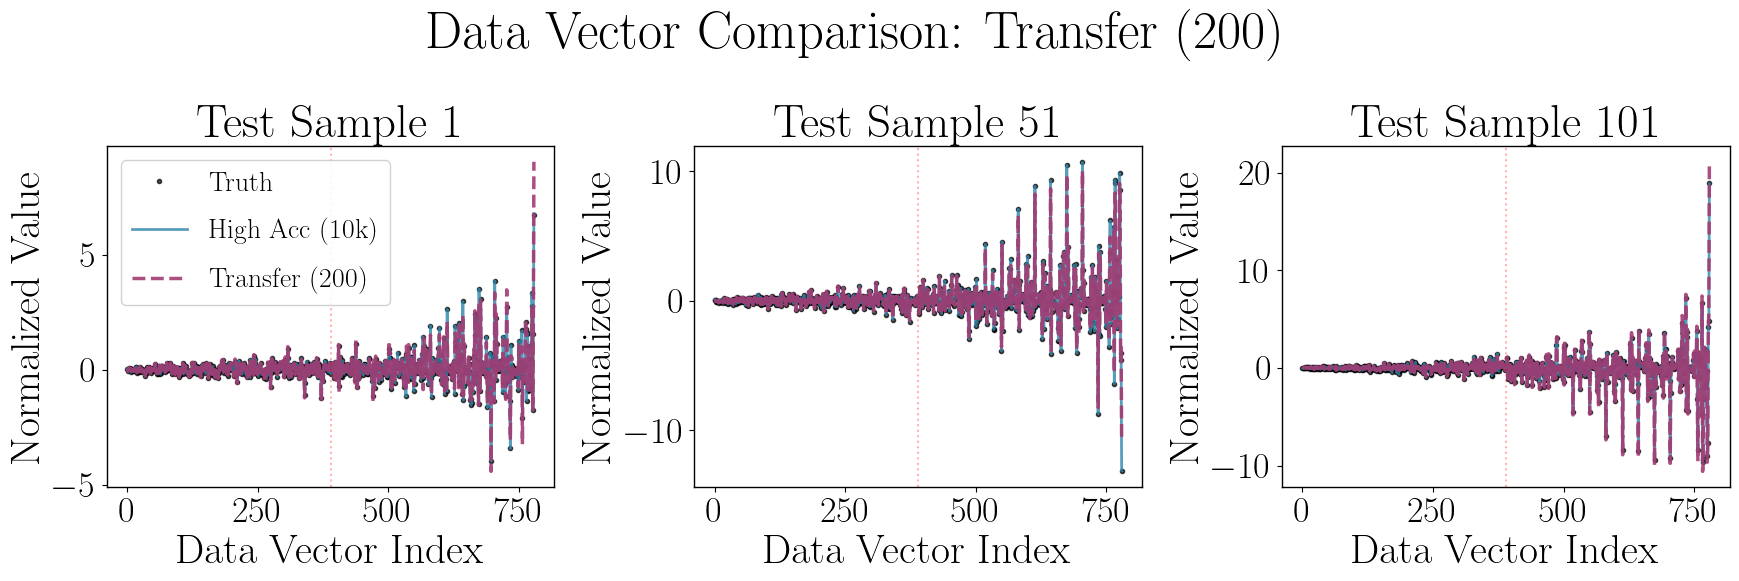

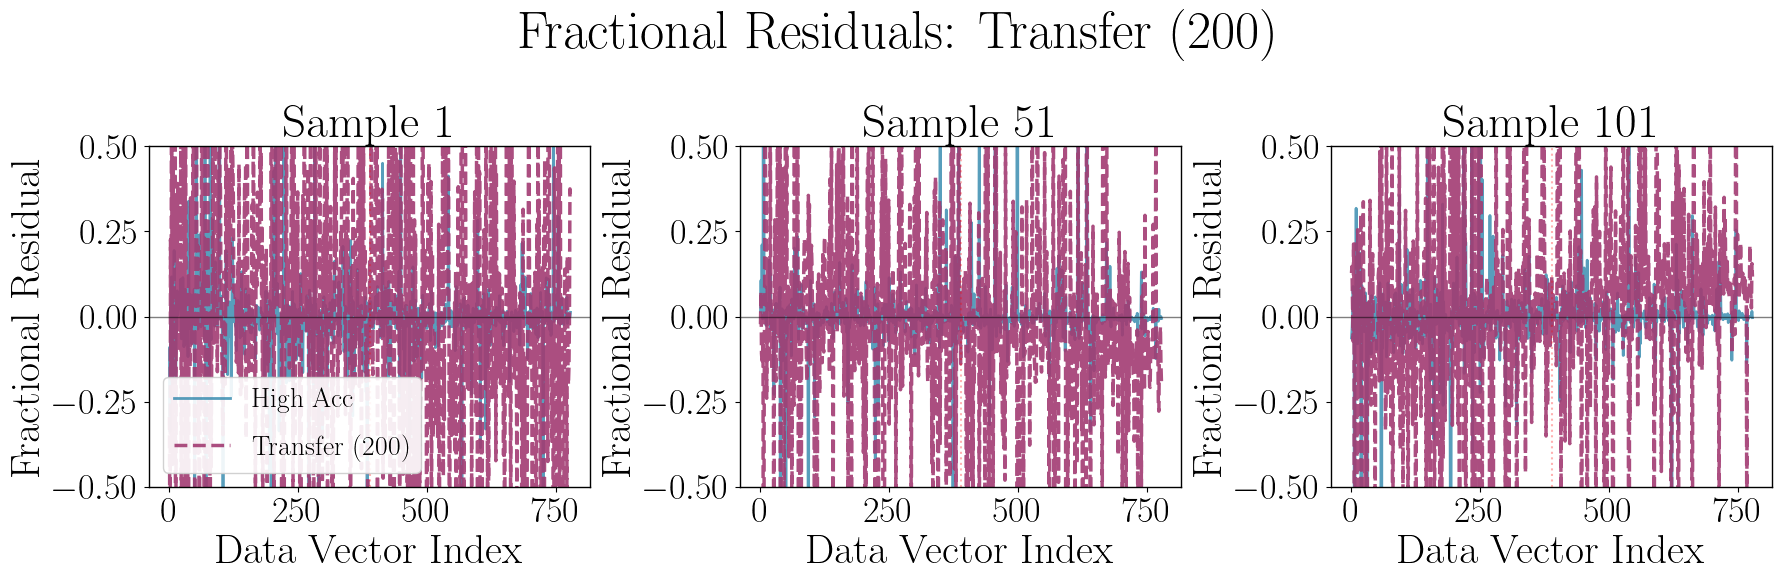

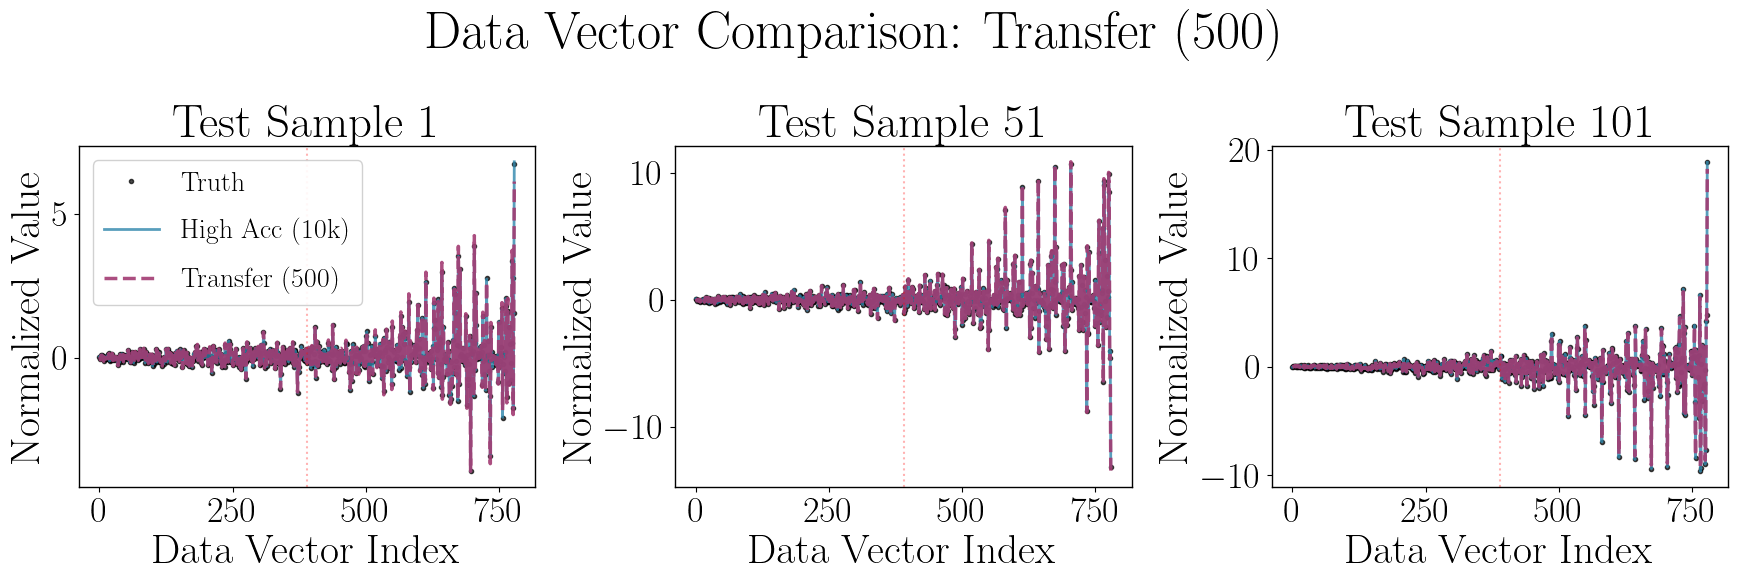

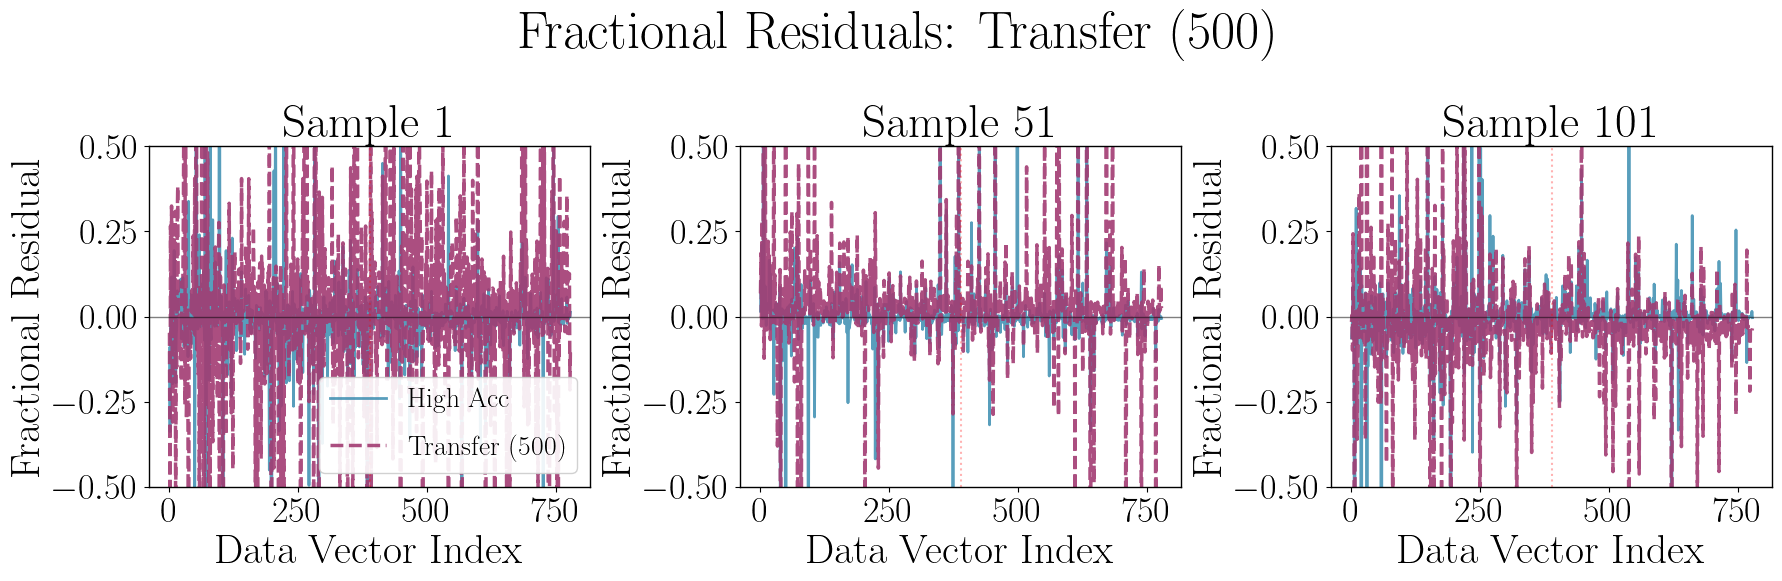

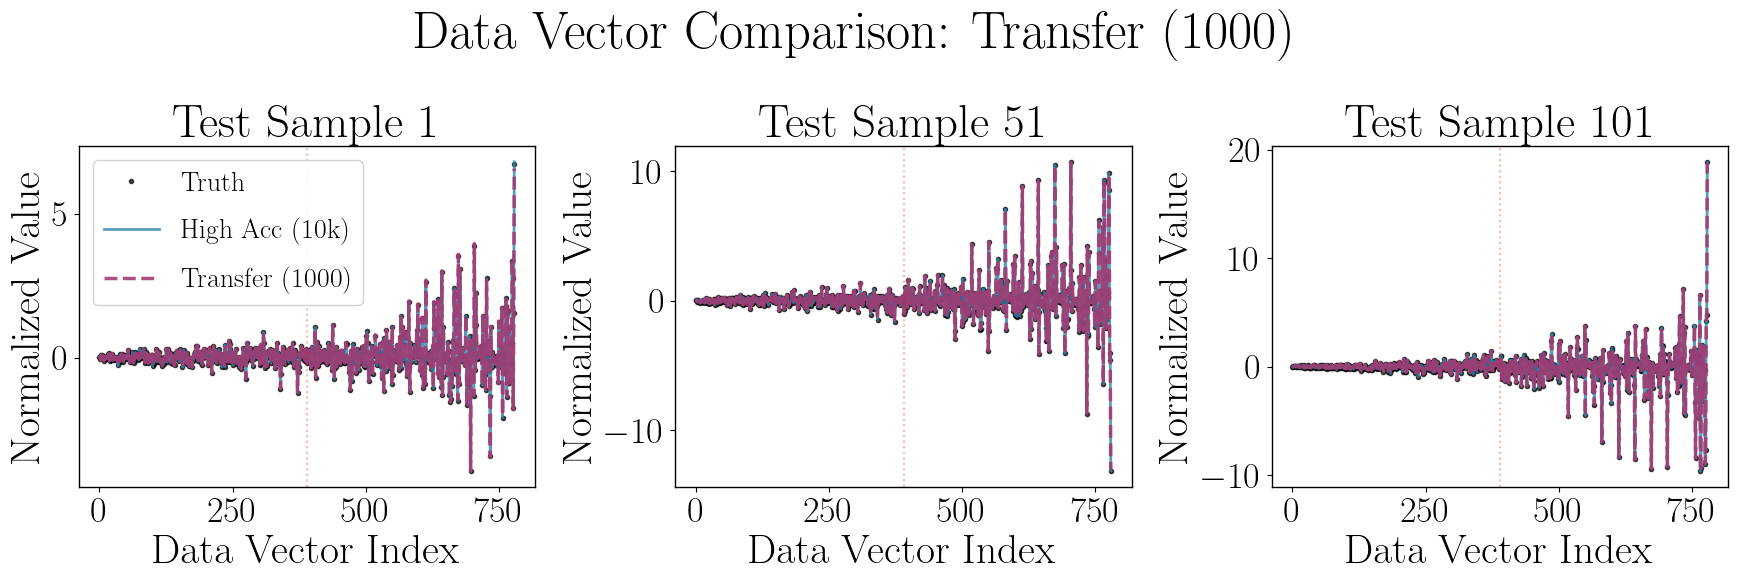

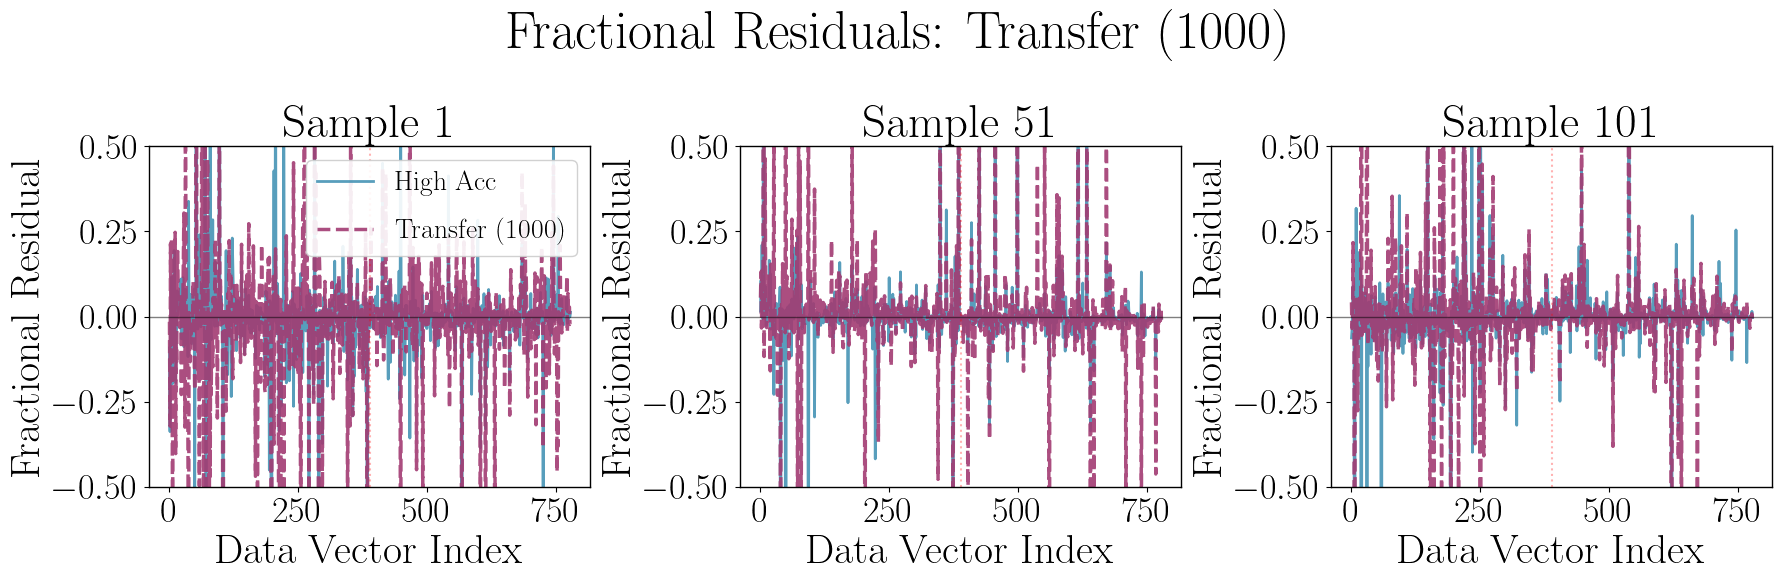

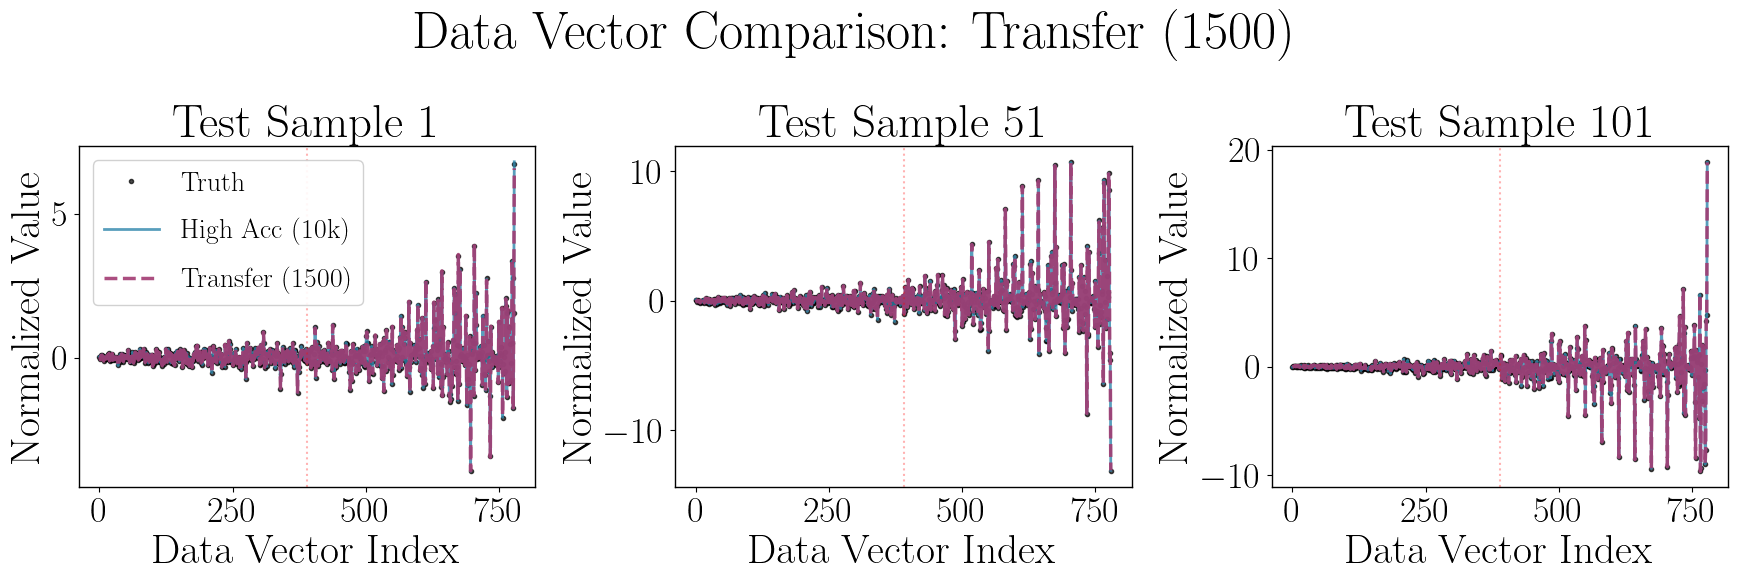

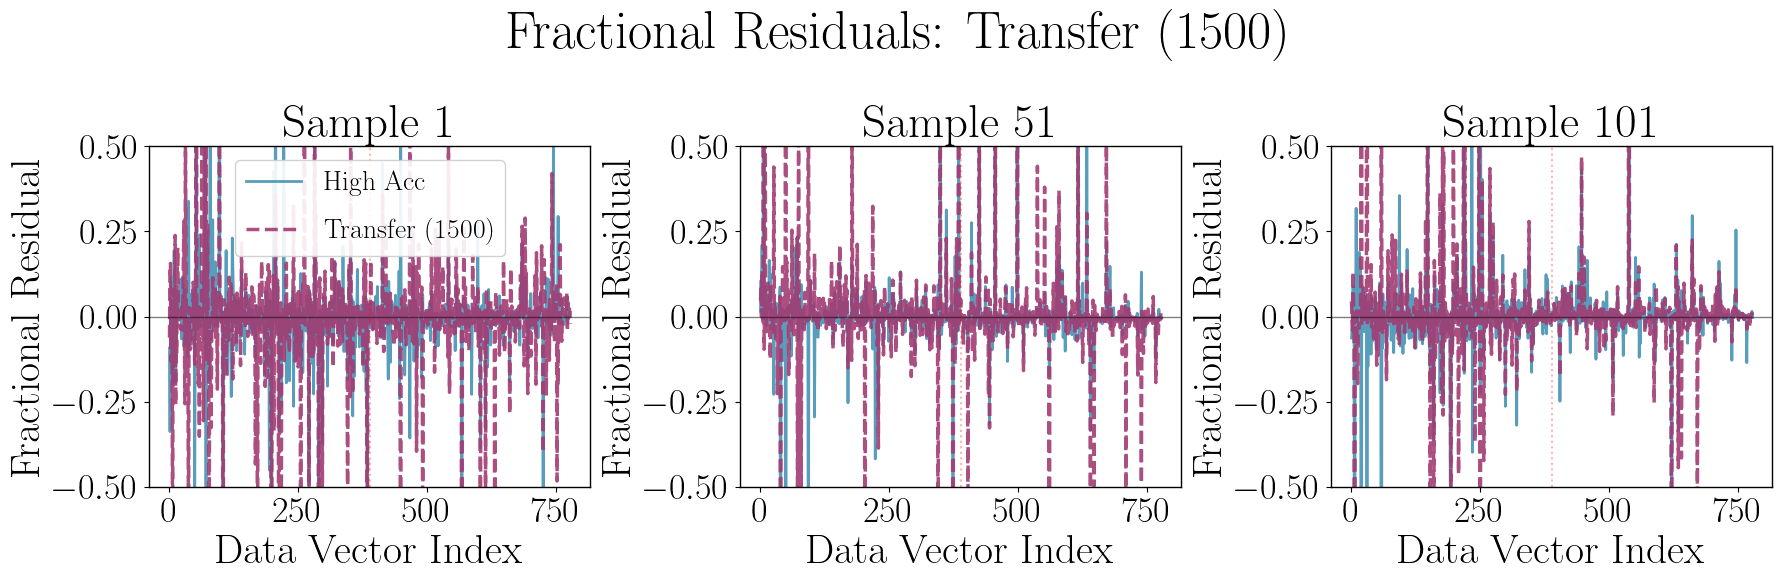

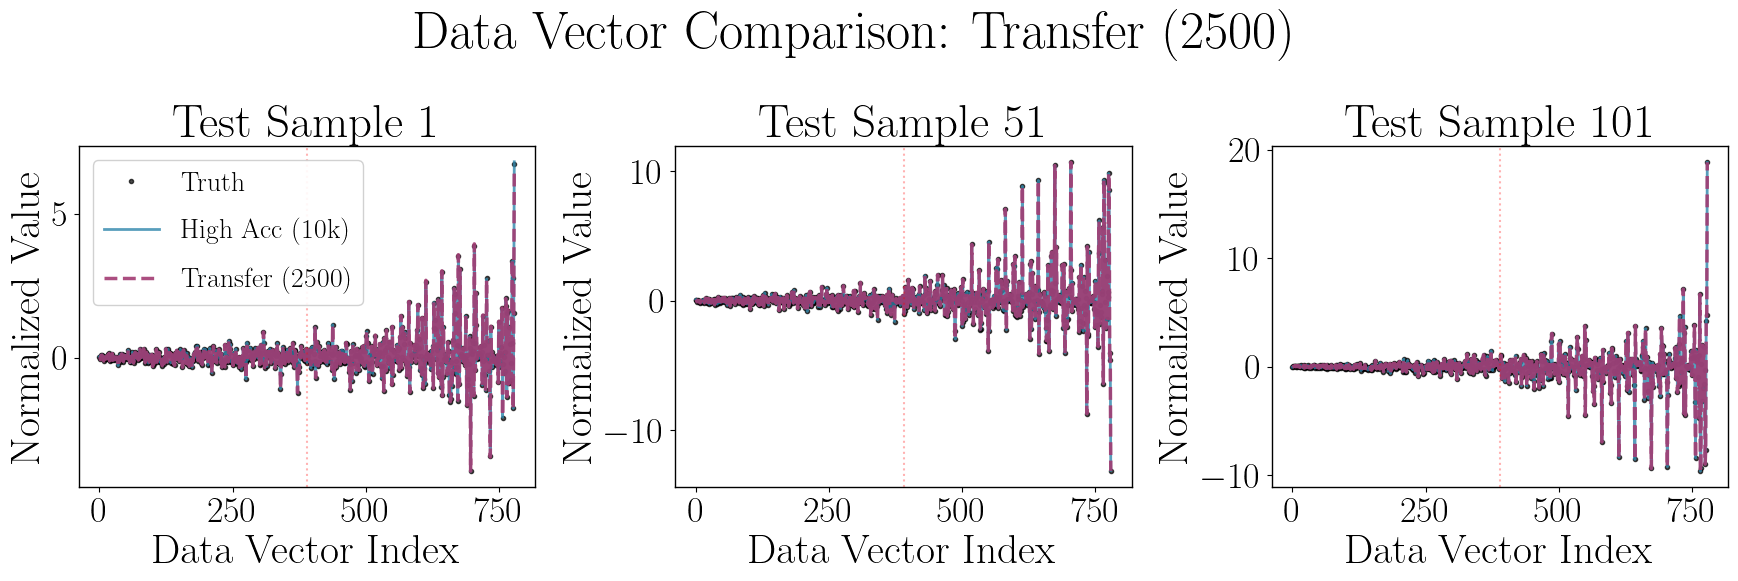

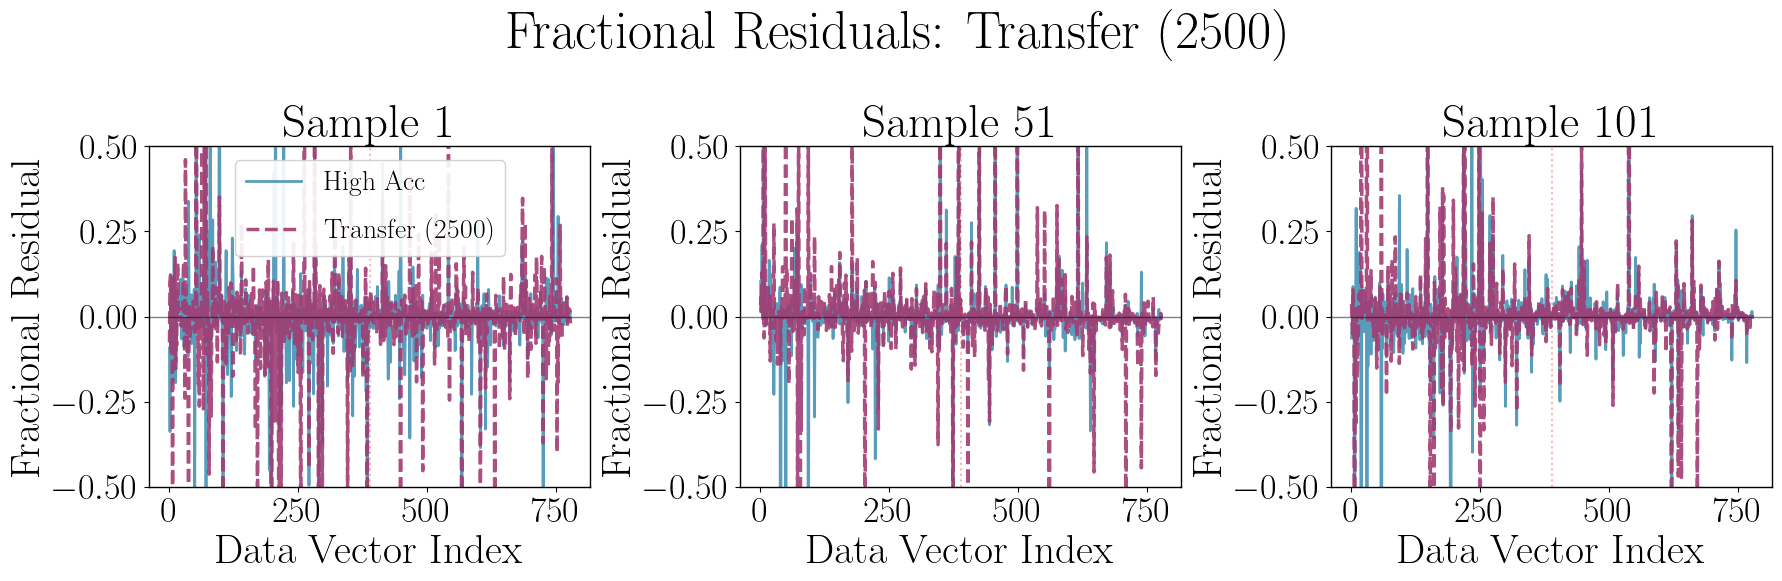

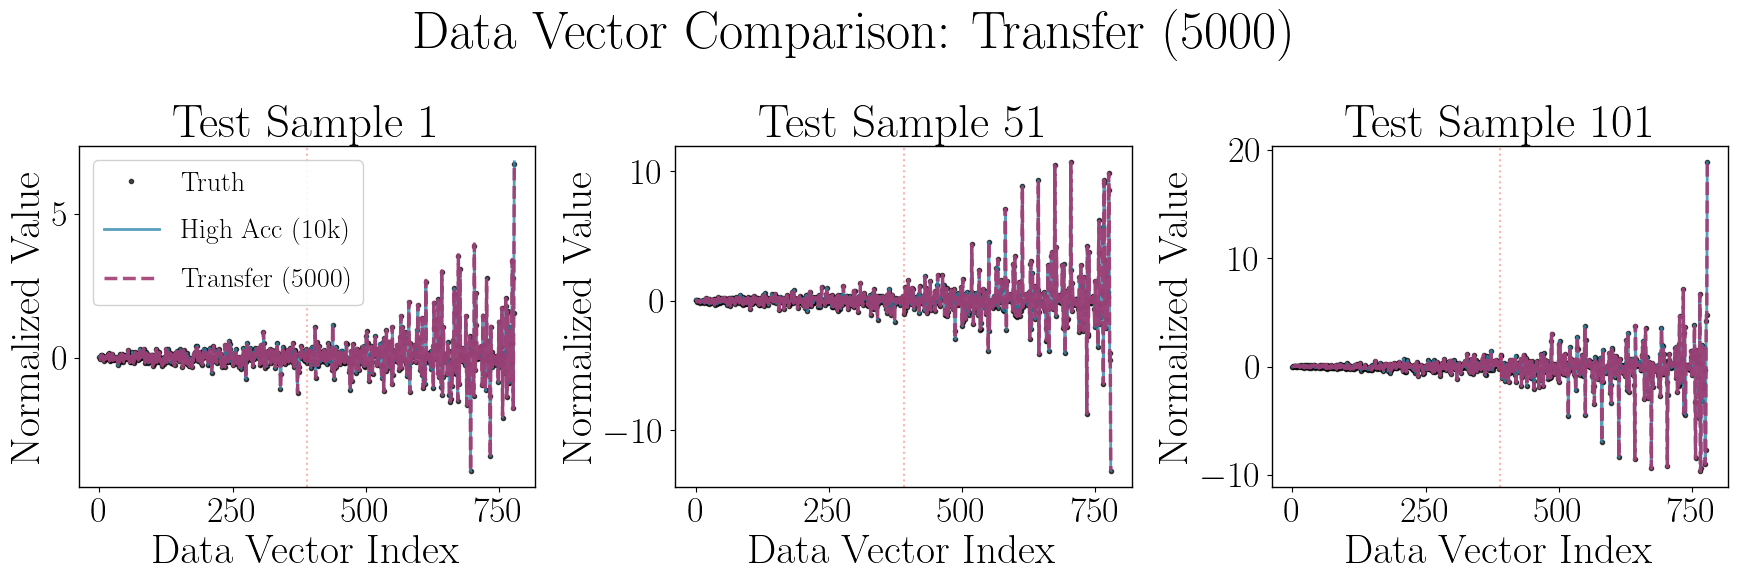

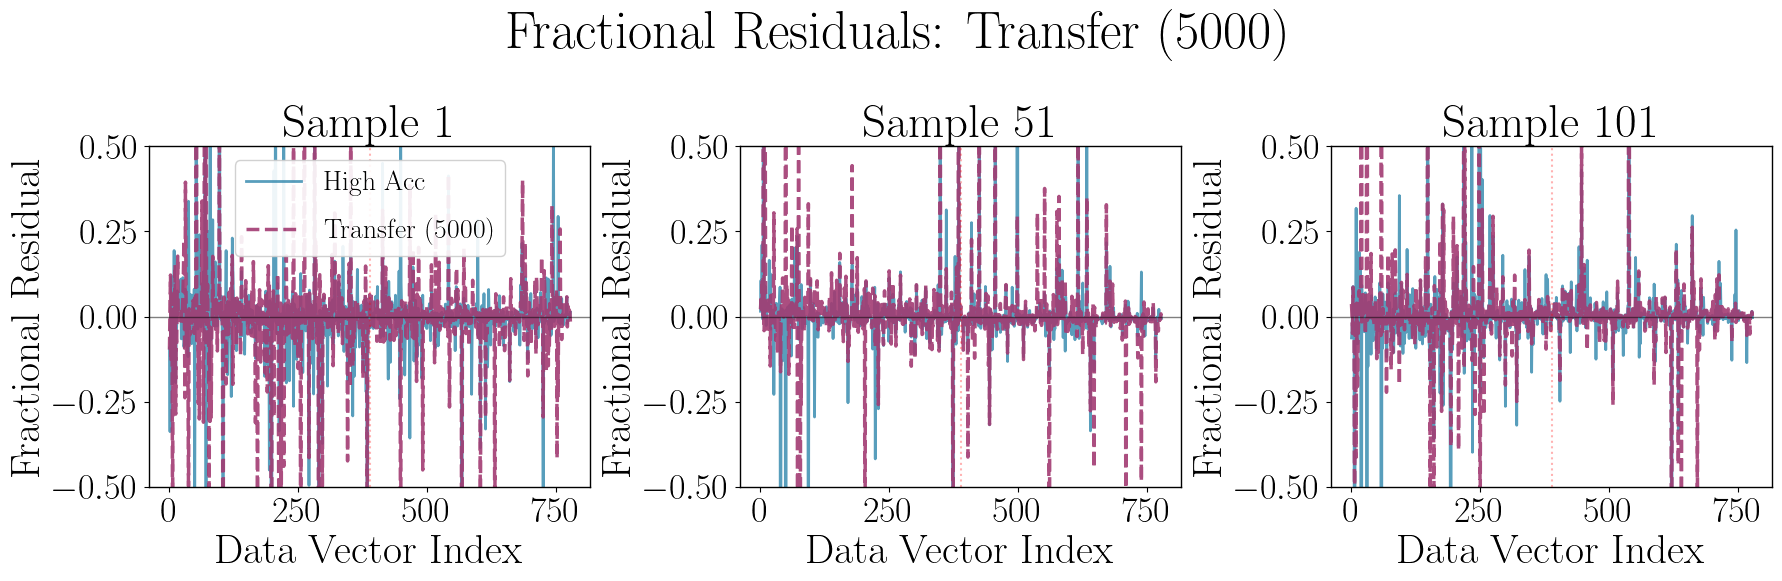

In [9]:
# ============================================================================
# FUNCTION: Plot data vector comparisons
# ============================================================================
def plot_data_vectors(model_key, model_label, test_indices=[0, 50, 100]):
    """
    Plot data vector comparisons for 3 test samples
    
    Parameters:
    -----------
    model_key : str
        Key for the model in predictions dict (e.g., 'transfer_1000')
    model_label : str
        Display label for legend (e.g., 'Transfer (1k)')
    test_indices : list
        Which test samples to plot
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    y_ref = y_test_normalized['high_acc']
    
    for col, idx in enumerate(test_indices):
        ax = axes[col]
        
        ax.plot(y_ref[idx], 'o', color='black', 
                label='Truth', markersize=3, alpha=0.7)
        ax.plot(predictions['high_acc'][idx], '-', color=colors['high_acc'],
                label='High Acc (10k)', linewidth=2, alpha=0.8)
        ax.plot(predictions[model_key][idx], '--', color=colors['transfer'],
                label=model_label, linewidth=2.5, alpha=0.9)
        
        ax.axvline(390, color='red', linestyle=':', alpha=0.3, linewidth=1.5)
        ax.set_xlabel('Data Vector Index')
        ax.set_ylabel('Normalized Value')
        ax.set_title(f'Test Sample {idx+1}', fontweight='bold')
        if col == 0:
            ax.legend(loc='best', framealpha=0.9)
    
    plt.suptitle(f'Data Vector Comparison: {model_label}', fontweight='bold')
    plt.tight_layout()
    # plt.savefig(f'data_vectors_{model_key}.pdf', format="pdf", bbox_inches="tight", dpi=300, pad_inches=0.05)
    # print(f"✓ Saved: data_vectors_{model_key}.pdf")
    plt.show()

# ============================================================================
# FUNCTION: Plot fractional residuals
# ============================================================================
def plot_fractional_residuals(model_key, model_label, test_indices=[0, 50, 100]):
    """
    Plot fractional residuals for 3 test samples
    
    Parameters:
    -----------
    model_key : str
        Key for the model in predictions dict (e.g., 'transfer_1000')
    model_label : str
        Display label for legend (e.g., 'Transfer (1k)')
    test_indices : list
        Which test samples to plot
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    y_ref = y_test_normalized['high_acc']
    
    for col, idx in enumerate(test_indices):
        ax = axes[col]
        
        frac_high = (predictions['high_acc'][idx] - y_ref[idx]) / y_ref[idx]
        frac_model = (predictions[model_key][idx] - y_ref[idx]) / y_ref[idx]
        
        ax.plot(frac_high, '-', color=colors['high_acc'], 
                label='High Acc', linewidth=2, alpha=0.8)
        ax.plot(frac_model, '--', color=colors['transfer'], 
                label=model_label, linewidth=2.5, alpha=0.9)
        ax.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
        ax.axvline(390, color='red', linestyle=':', alpha=0.3, linewidth=1.5)
        
        ax.set_xlabel('Data Vector Index')
        ax.set_ylabel('Fractional Residual')
        ax.set_title(f'Sample {idx+1}', fontweight='bold')
        ax.set_ylim(-0.5, 0.5)
        if col == 0:
            ax.legend(loc='best', framealpha=0.9)
    
    plt.suptitle(f'Fractional Residuals: {model_label}', fontweight='bold')
    plt.tight_layout()
    # plt.savefig(f'fractional_residuals_{model_key}.pdf', format="pdf", bbox_inches="tight", dpi=300, pad_inches=0.05)
    # print(f"✓ Saved: fractional_residuals_{model_key}.pdf")
    plt.show()

# ============================================================================
# USAGE EXAMPLES
# ============================================================================
# # For transfer_1000:
# plot_data_vectors('transfer_1000', 'Transfer (1k)')
# plot_fractional_residuals('transfer_1000', 'Transfer (1k)')

# # For transfer_2500:
# plot_data_vectors('transfer_2500', 'Transfer (2500)')
# plot_fractional_residuals('transfer_2500', 'Transfer (2500)')

# For any size:
for size in [200, 500, 1000, 1500, 2500, 5000]:
    plot_data_vectors(f'transfer_{size}', f'Transfer ({size})')
    plot_fractional_residuals(f'transfer_{size}', f'Transfer ({size})')

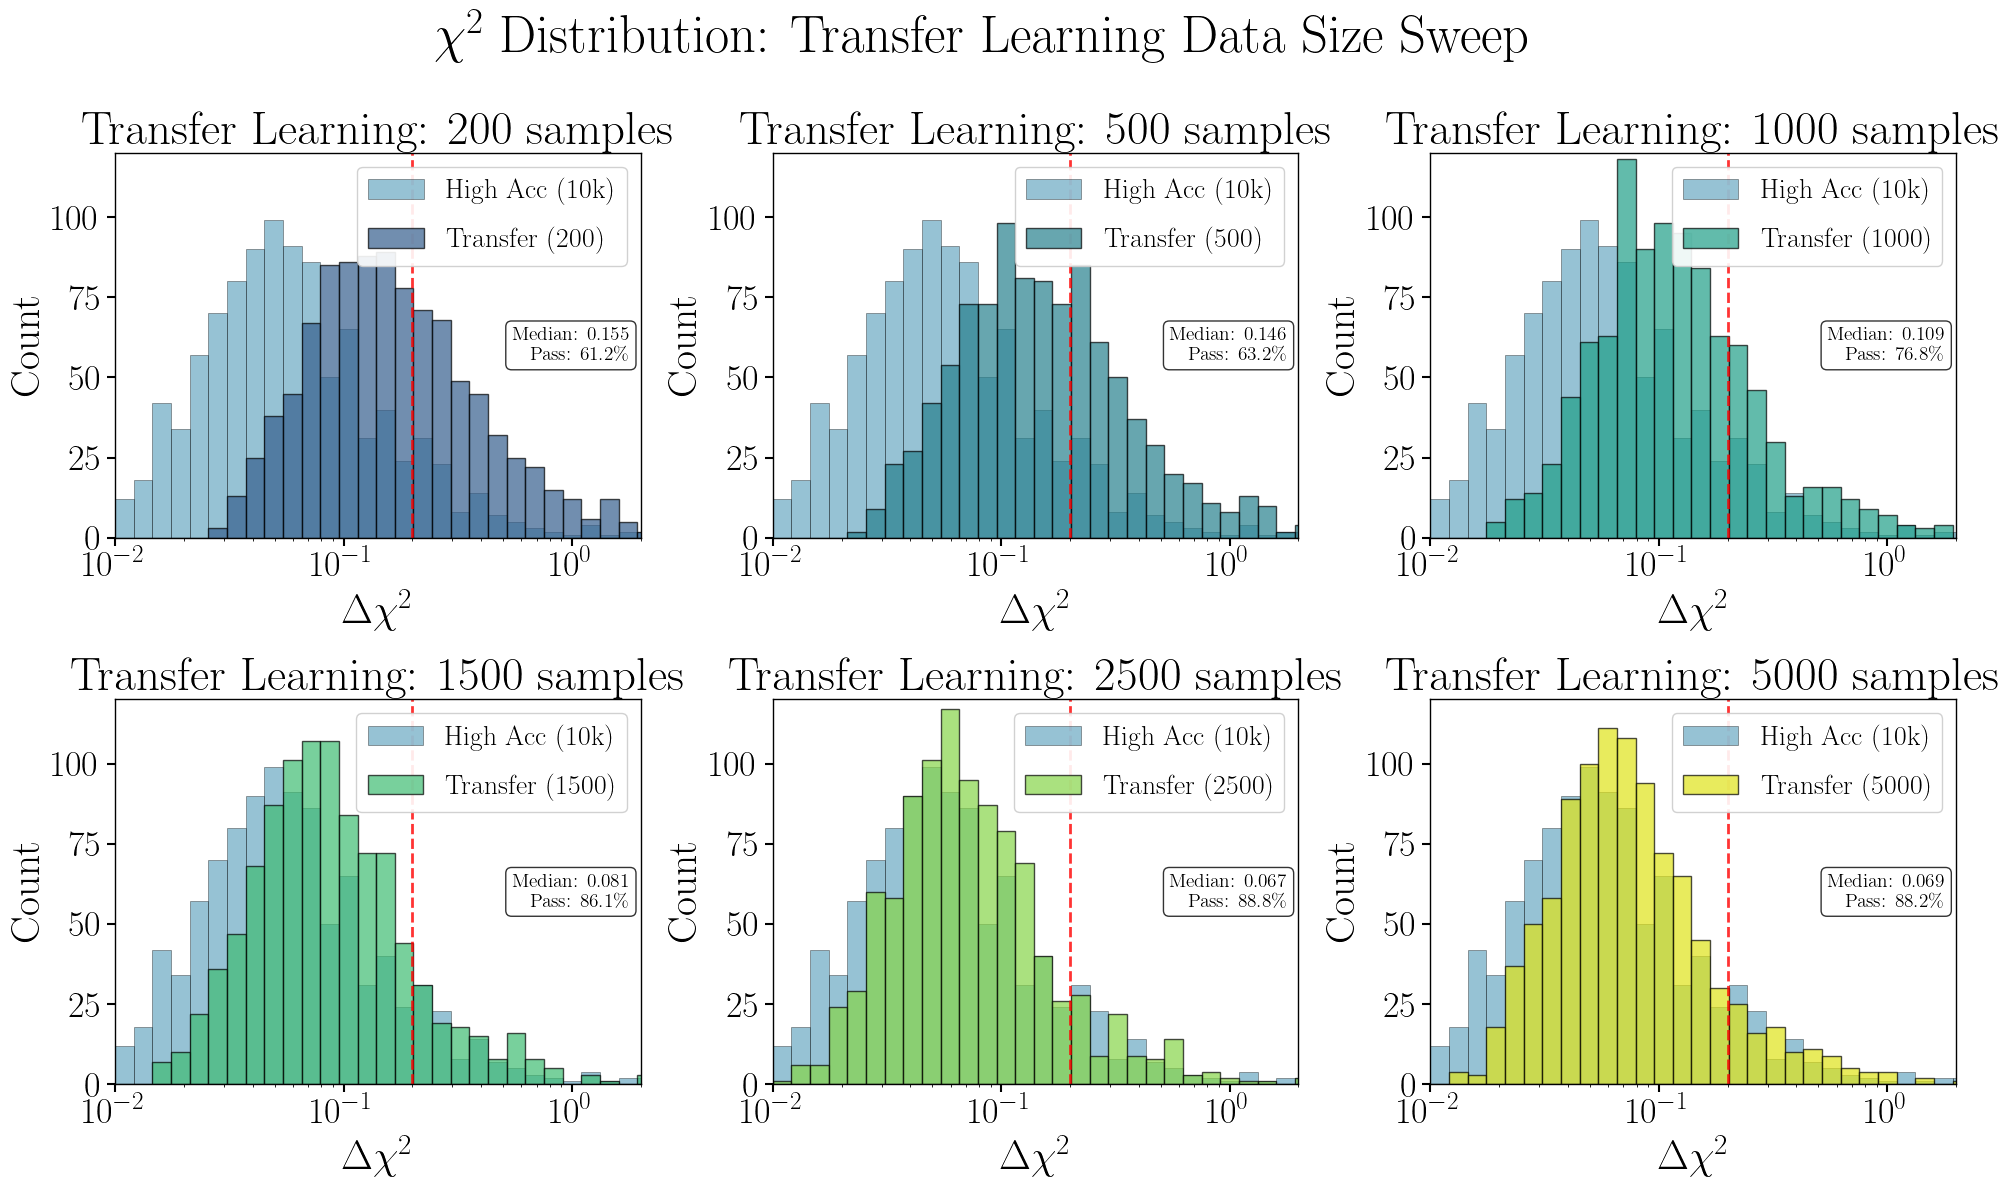

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

bins = np.logspace(-2, 2, 50)
transfer_colors = plt.cm.viridis(np.linspace(0.3, 0.95, len(sizes)))

for i, size in enumerate(sizes):
    ax = axes[i]
    key = f'transfer_{size}'
    
    if key in chi_squared_results:
        # Plot baseline
        ax.hist(chi_squared_results['high_acc'], bins=bins, alpha=0.5, 
                color=colors['high_acc'], label='High Acc (10k)', 
                edgecolor='black', linewidth=0.5)
        
        # Plot this transfer model
        ax.hist(chi_squared_results[key], bins=bins, alpha=0.7,
                color=transfer_colors[i], label=f'Transfer ({size})', 
                edgecolor='black', linewidth=1)
        
        # DES-Y3 threshold
        ax.axvline(0.2, color='red', linestyle='--', linewidth=2, alpha=0.8)
        
        ax.set_xscale('log')
        ax.set_ylim(0, 120)
        ax.set_xlim(1e-2, 2)
        ax.set_xlabel(r'$\Delta\chi^2$')
        ax.set_ylabel('Count')
        ax.tick_params(direction='out', length=6, width=1.5)
        ax.set_title(f'Transfer Learning: {size} samples', fontweight='bold')
        ax.legend(loc='upper right', framealpha=0.9)
        
        # Add median as text
        median = np.median(chi_squared_results[key])
        pass_rate = np.sum(chi_squared_results[key] < 0.2) / len(chi_squared_results[key]) * 100
        ax.text(0.98, 0.5, f'Median: {median:.3f}\nPass: {pass_rate:.1f}\%', 
                transform=ax.transAxes, ha='right', va='center',
                fontsize=14, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle(r'$\chi^2$ Distribution: Transfer Learning Data Size Sweep', 
             fontweight='bold', y=0.995)
plt.tight_layout()
# plt.savefig('transfer_learning_sweep_panels.pdf', format="pdf", bbox_inches="tight", dpi=300, pad_inches=0.05)
# print("✓ Saved: transfer_learning_sweep_panels.pdf")
plt.show()

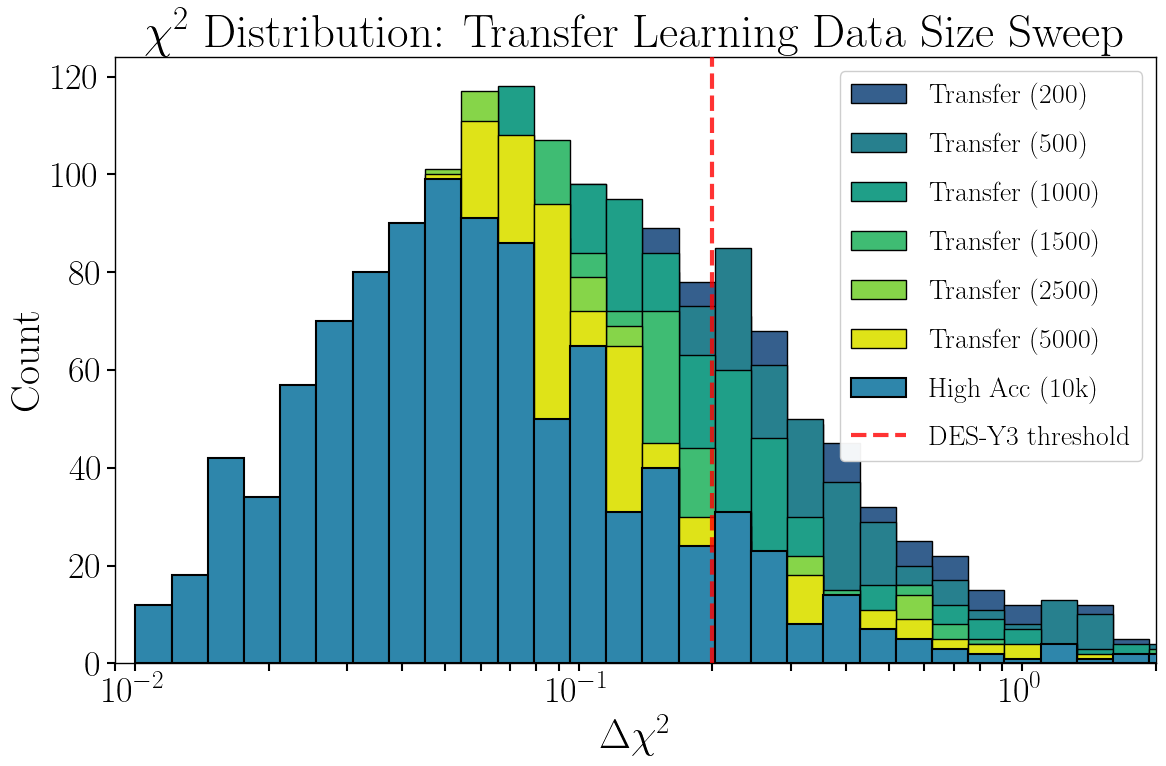

In [11]:
# ============================================================================
# FIGURE: χ² DISTRIBUTION - ALL MODELS WITH HIGH ACC EMPHASIZED
# ============================================================================
fig, ax = plt.subplots(figsize=(12, 8))
bins = np.logspace(-2, 2, 50)

# Plot all transfer models with color gradient (middle layer)
transfer_colors = plt.cm.viridis(np.linspace(0.3, 0.95, len(sizes)))
# bold_colors = ('purple', 'red', 'orange', 'green')
# hatches = ('X', '/', '|', '-')
for i, size in enumerate(sizes):
    key = f'transfer_{size}'
    if key in chi_squared_results:
        ax.hist(chi_squared_results[key], bins=bins, alpha=1,
                color=transfer_colors[i], label=f'Transfer ({size})',  
                edgecolor='black', linewidth=1) # if hatching: hatch=hatches[i],

# Plot HIGH ACCURACY LAST (emphasized on top)
ax.hist(chi_squared_results['high_acc'], bins=bins, alpha=1, 
        color=colors['high_acc'], label='High Acc (10k)', 
        edgecolor='black', linewidth=1.5, zorder=10)  # zorder puts it on top

# DES-Y3 threshold
ax.axvline(0.2, color='red', linestyle='--', linewidth=3, 
           label='DES-Y3 threshold', alpha=0.8, zorder=11)

ax.set_xscale('log')
ax.set_xlim(9e-3, 2)
ax.set_xlabel(r'$\Delta\chi^2$')
ax.set_ylabel('Count')
ax.tick_params(direction='out', length=6, width=1.5, which='both')
ax.set_title(r'$\chi^2$ Distribution: Transfer Learning Data Size Sweep', fontweight='bold')
ax.legend(loc='upper right', framealpha=0.95)  # , ncol=2 # 2 columns to fit everything

plt.tight_layout()
# plt.savefig('chi2_distribution_all_models_emphasized.pdf', format="pdf", bbox_inches="tight", dpi=300, pad_inches=0.05)
# print("✓ Saved: chi2_distribution_all_models_emphasized.pdf")
plt.show()

✓ Saved: chi2_distribution_one_models_emphasized.pdf


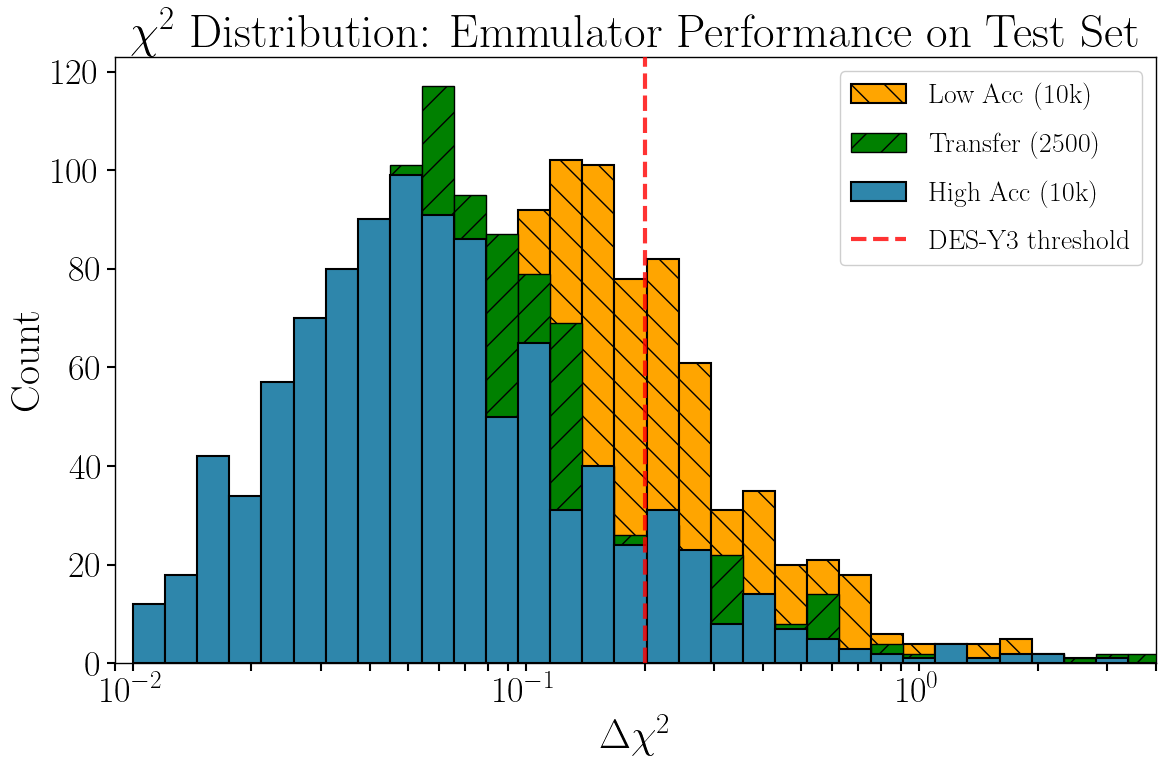

In [12]:
# ============================================================================
# FIGURE: χ² DISTRIBUTION - ONE MODEL WITH HIGH AND LOW ACC EMPHASIZED
# ============================================================================
fig, ax = plt.subplots(figsize=(12, 8))
bins = np.logspace(-2, 2, 50)

# Plot low accuracy first (background)
ax.hist(chi_squared_results['low_acc'], bins=bins, alpha=1,
        color='orange', hatch='\\', label='Low Acc (10k)', 
        edgecolor='black', linewidth=1.5) 

# Plot single transfer models with color gradient (middle layer)
ax.hist(chi_squared_results['transfer_2500'], bins=bins, alpha=1,
                color='green', hatch='/', label=f'Transfer (2500)', 
                edgecolor='black', linewidth=1)

# Plot HIGH ACCURACY LAST (emphasized on top)
ax.hist(chi_squared_results['high_acc'], bins=bins, alpha=1, 
        color=colors['high_acc'], label='High Acc (10k)', 
        edgecolor='black', linewidth=1.5, zorder=10)  # zorder puts it on top

# DES-Y3 threshold
ax.axvline(0.2, color='red', linestyle='--', linewidth=3, 
           label='DES-Y3 threshold', alpha=0.8, zorder=11)

ax.set_xscale('log')
ax.set_xlim(9e-3, 4)
ax.set_xlabel(r'$\Delta\chi^2$')
ax.set_ylabel('Count')
ax.tick_params(direction='out', length=6, width=1.5, which='both')
ax.set_title(r'$\chi^2$ Distribution: Emmulator Performance on Test Set', fontweight='bold')
ax.legend(loc='upper right', framealpha=0.95)  # , ncol=2 # 2 columns to fit everything

plt.tight_layout()
plt.savefig('chi2_distribution_one_models_emphasized.pdf', format="pdf", bbox_inches="tight", dpi=300, pad_inches=0.05)
print("✓ Saved: chi2_distribution_one_models_emphasized.pdf")
plt.show()

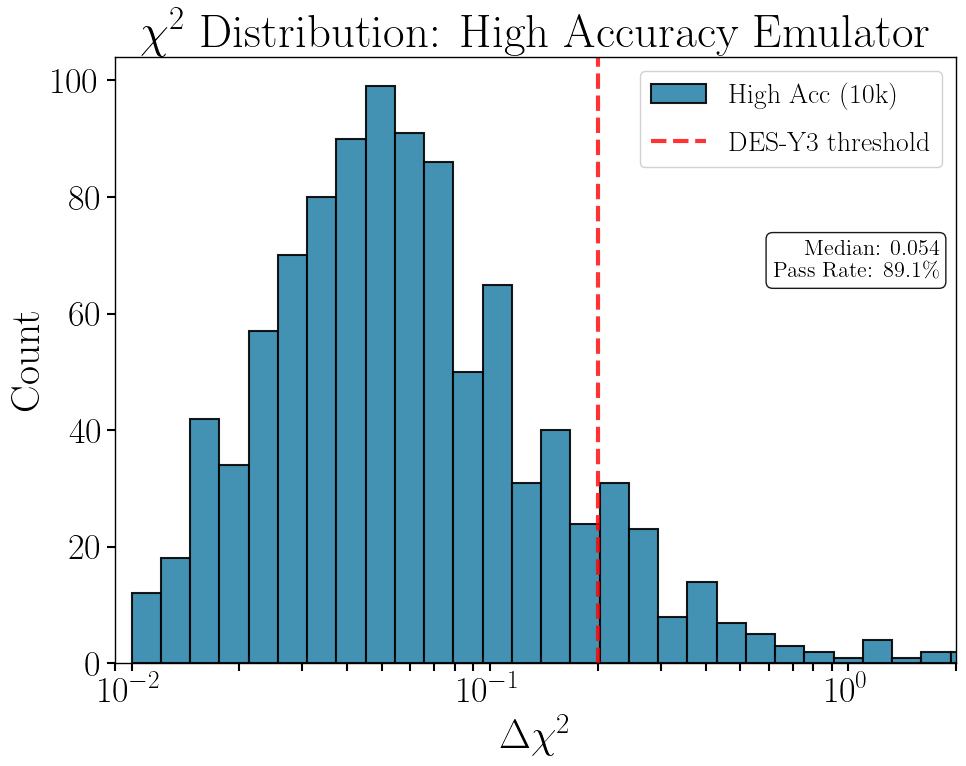

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.hist(chi_squared_results['high_acc'], bins=bins, alpha=0.9, 
        color=colors['high_acc'], label='High Acc (10k)', 
        edgecolor='black', linewidth=1.5)

ax.axvline(0.2, color='red', linestyle='--', linewidth=3, 
           label='DES-Y3 threshold', alpha=0.8)

ax.set_xscale('log')
ax.set_xlim(9e-3, 2)
ax.set_xlabel(r'$\Delta\chi^2$')
ax.set_ylabel('Count')
ax.tick_params(direction='out', length=6, width=1.5, which='both')
ax.set_title(r'$\chi^2$ Distribution: High Accuracy Emulator', fontweight='bold')
ax.legend(loc='upper right', framealpha=0.9)

# Add stats
median = np.median(chi_squared_results['high_acc'])
pass_rate = np.sum(chi_squared_results['high_acc'] < 0.2) / len(chi_squared_results['high_acc']) * 100
ax.text(0.98, 0.70, f'Median: {median:.3f}\nPass Rate: {pass_rate:.1f}\%', 
        transform=ax.transAxes, ha='right', va='top',
        fontsize=16, bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.tight_layout()
# plt.savefig('high_accuracy_chi2_distribution.pdf', format="pdf", bbox_inches="tight", dpi=300, pad_inches=0.05)
# print("✓ Saved: high_accuracy_chi2_distribution.pdf")
plt.show()

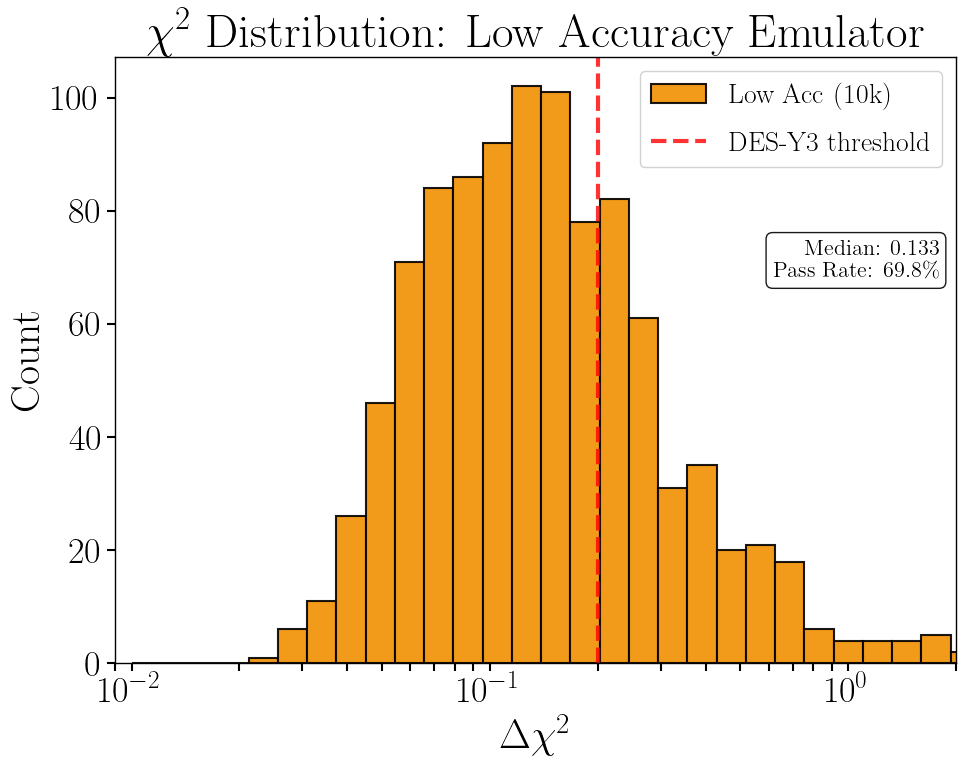

In [38]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.hist(chi_squared_results['low_acc'], bins=bins, alpha=0.9,
        color=colors['low_acc'], label='Low Acc (10k)', 
        edgecolor='black', linewidth=1.5)

ax.axvline(0.2, color='red', linestyle='--', linewidth=3, 
           label='DES-Y3 threshold', alpha=0.8)

ax.set_xscale('log')
ax.set_xlim(9e-3, 2)
ax.set_xlabel(r'$\Delta\chi^2$')
ax.set_ylabel('Count')
ax.tick_params(direction='out', length=6, width=1.5, which='both')
ax.set_title(r'$\chi^2$ Distribution: Low Accuracy Emulator', fontweight='bold')
ax.legend(loc='upper right', framealpha=0.9)

# Add stats
median = np.median(chi_squared_results['low_acc'])
pass_rate = np.sum(chi_squared_results['low_acc'] < 0.2) / len(chi_squared_results['low_acc']) * 100
ax.text(0.98, 0.70, f'Median: {median:.3f}\nPass Rate: {pass_rate:.1f}\%', 
        transform=ax.transAxes, ha='right', va='top',
        fontsize=16, bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.tight_layout()
# plt.savefig('low_accuracy_chi2_distribution.pdf', format="pdf", bbox_inches="tight", dpi=300, pad_inches=0.05)
# print("✓ Saved: low_accuracy_chi2_distribution.pdf")
plt.show()

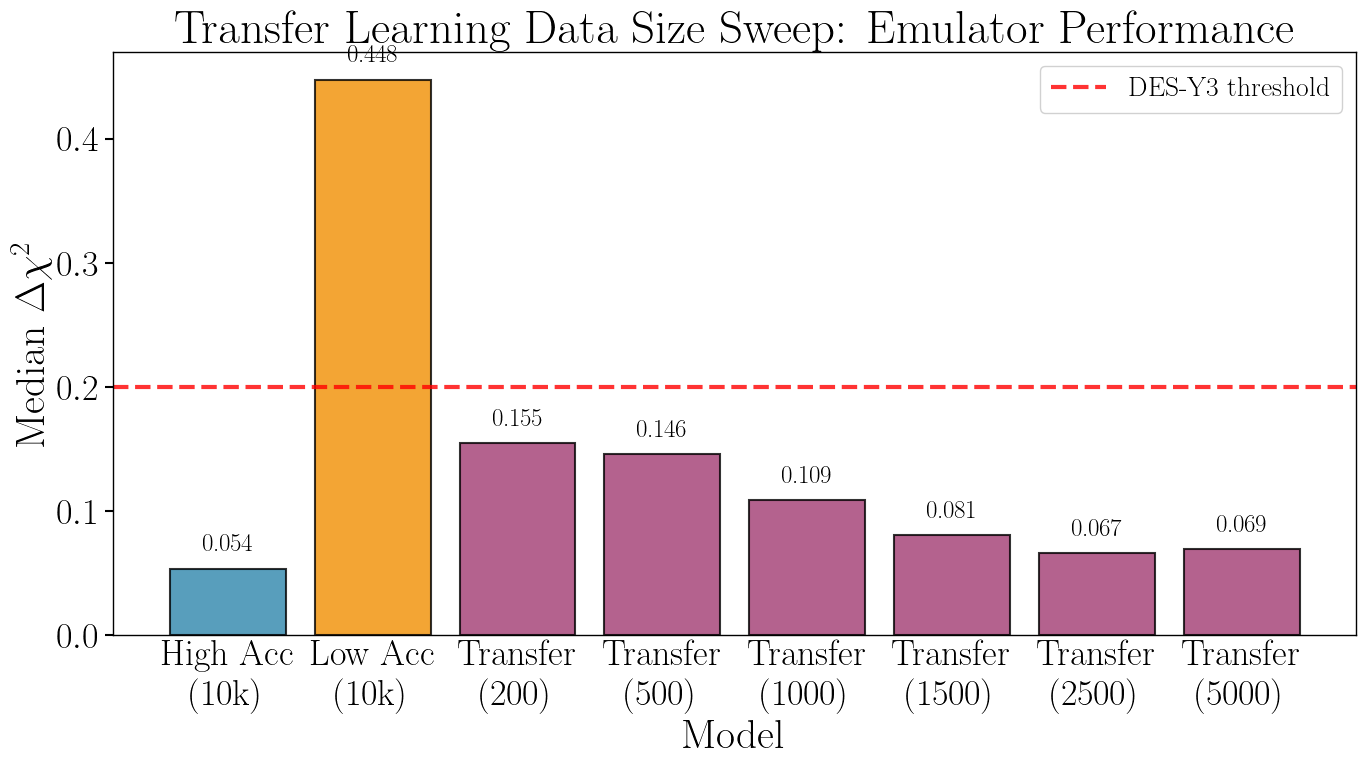

In [20]:
# ============================================================================
# FIGURE: MEDIAN χ² COMPARISON - DATA SIZE SWEEP
# ============================================================================
fig, ax = plt.subplots(figsize=(14, 8))

# Prepare data for all models
models_list = ['High Acc\n(10k)', 'Low Acc\n(10k)']
chi2_medians = [
    np.median(chi_squared_results['high_acc']),
    np.median(chi_squared_results['low_acc'])
]
colors_bar = [colors['high_acc'], colors['low_acc']]

# Add all transfer learning models
for size in sizes:
    key = f'transfer_{size}'
    if key in chi_squared_results:
        models_list.append(f'Transfer\n({size})')
        chi2_medians.append(np.median(chi_squared_results[key]))
        colors_bar.append(colors['transfer'])

# Create bars
bars = ax.bar(models_list, chi2_medians, color=colors_bar, alpha=0.8, 
              edgecolor='black', linewidth=1.5)

# DES-Y3 threshold line
ax.axhline(0.2, color='red', linestyle='--', linewidth=3, 
           label='DES-Y3 threshold', alpha=0.8)

ax.set_xlabel('Model')
ax.set_ylim(0, .5)
ax.set_ylabel(r'Median $\Delta\chi^2$')
ax.tick_params(axis='y', direction='out', length=6, width=1.5)
ax.tick_params(axis='x', length=0, width=0)
ax.set_title('Transfer Learning Data Size Sweep: Emulator Performance', fontweight='bold')
ax.legend(loc='upper right', framealpha=0.9)

# Add value labels on bars
for bar, val in zip(bars, chi2_medians):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f'{val:.3f}', ha='center', va='bottom', 
            fontweight='bold')

plt.tight_layout()
# plt.savefig('data_size_sweep_median_chi2.pdf', format="pdf", bbox_inches="tight", dpi=300, pad_inches=0.05)
# print("✓ Saved: data_size_sweep_median_chi2.pdf")
plt.show()

---
## 7. Summary and Conclusions

### Key Findings

**1. Transfer Learning Scaling Law:**
- 200 samples: 61% pass rate (preliminary studies)
- 1,000 samples: 77% pass rate (10× data reduction)
- **2,500 samples: 89% pass rate** (matches baseline with 4× reduction!)
- 5,000 samples: 88% pass rate (validates convergence)

**2. Optimal Training Size:**
- **2,500 high-accuracy samples** achieve baseline-level performance
- Beyond this, diminishing returns (5,000 samples show minimal improvement)
- Below 1,000 samples, performance degrades significantly

**3. Computational Savings:**
- **4× reduction in expensive simulations** while maintaining DES-Y3 requirements
- At 1,000 samples: 10× reduction with reasonable accuracy for many applications
- Even 200 samples provide useful preliminary results

**4. Critical Technical Details:**
- Input preprocessing requires factor of 5: `(X - mean) / (5*std)`
- Freezing strategy (early_2) freezes input layer + first ResBlock (22.6% of parameters)
- Models must be tested on data matching their training fidelity (low vs high accuracy)

### Implications for Stage-IV Surveys

Transfer learning enables **rapid emulator development** for survey pipelines:
- Start with low-accuracy training (cheap, fast)
- Fine-tune with 2,500 high-accuracy samples
- Achieve full accuracy at 25% of traditional computational cost